In [21]:
import os    
import pandas as pd
import ollama
import chromadb
import re
import sqlite3
import random
import matplotlib.pyplot as plt

In [22]:
client = chromadb.PersistentClient(path="full_data/")

In [ ]:
def retrieveID(paper_name, cursor):
    connection = sqlite3.connect("papers.db")
    cursor = connection.cursor()

    query = """
    SELECT paper_id FROM papers
    WHERE title = ? and authors is not null and abstract is not null
    Limit 1
    """
    cursor.execute(query, (paper_name,))
    results = cursor.fetchall()
    
    return(results[0][0])



In [24]:
def retrieveID_batch(paper_names, cursor):

    placeholders = ','.join(['?' for _ in paper_names])
    
    query = f"""
    SELECT title, paper_id FROM papers
    WHERE title IN ({placeholders}) and authors is not null and abstract is not null
    """

    cursor.execute(query, paper_names)
    results = cursor.fetchall()

    mp = {result[0]: result[1] for result in results}

    ids_list = [mp[name] for name in paper_names]

    return ids_list


In [25]:
def get_similar_abstract(paper_id, cursor, limit=30):

    query = """
    SELECT abstract FROM papers
    WHERE paper_id = ?
    Limit 1
    """
    cursor.execute(query, (paper_id,))
    results = cursor.fetchall()
    abstract = results[0][0]
    if abstract is None:
      print(paper_id)
    collection = client.get_or_create_collection(name="docs")
    
    response = ollama.embed(
      input=[abstract],
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )

    data = results['ids'][0]
    return(data)

In [ ]:
def get_similar_abstract_batch(paper_ids, cursor, limit=30):
    paper_ids_str = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT paper_id,abstract FROM papers
    WHERE paper_id IN {paper_ids_str}
    """
    cursor.execute(query)
    results = cursor.fetchall()
    mp = {}
    for result in results:
        mp[result[0]] = result[1]
    abs_list = []
    for id_ in paper_ids:
      abs_list.append(mp[id_])
      if mp[id_] is None:
        print(id_)

    collection = client.get_or_create_collection(name="docs")
    
    response = ollama.embed(
      input=abs_list,
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )
    data = results['ids']
    return data

In [27]:
def get_similar_authors(paper_id, cursor,limit=30):

    query = """
    SELECT authors FROM papers
    WHERE paper_id = ?
    Limit 1
    """
    cursor.execute(query, (paper_id,))
    results = cursor.fetchall()
    author = results[0][0]
    
    collection = client.get_or_create_collection(name="authors")
    if author is None:
      print(paper_id)
    response = ollama.embed(
      input=author,
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )

    data = results['ids'][0]
    return(data)

In [ ]:
def get_similar_authors_batch(paper_ids, cursor,limit=30):
    paper_ids_str = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT paper_id,authors FROM papers
    WHERE paper_id IN {paper_ids_str}
    """
    cursor.execute(query)
    results = cursor.fetchall()
    mp = {}
    for result in results:
        mp[result[0]] = result[1]
    author_list = []
    for id_ in paper_ids:
      author_list.append(mp[id_])
      if mp[id_] is None:
        print(id_)

    
    collection = client.get_or_create_collection(name="authors")
    
    response = ollama.embed(
      input=author_list,
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )

    data = results['ids']
    return data

In [43]:
def find_co_citations(paper_id, cursor, limit = 30):
    query = """
    SELECT 
        CASE 
            WHEN paper_1_id = ? THEN paper_2_id
            ELSE paper_1_id
        END AS co_cited_paper_id,
        co_citation_count,
        pd.publication_date
    FROM co_citations
    JOIN paper_dates pd 
        ON pd.paper_id = CASE 
            WHEN paper_1_id = ? THEN paper_2_id
            ELSE paper_1_id
        END
    WHERE paper_1_id = ? OR paper_2_id = ?
    ORDER BY co_citation_count DESC, 
             pd.publication_date DESC
    LIMIT ?
    """
    cursor.execute(query, (paper_id, paper_id, paper_id, paper_id, limit))
    top_co_citations = cursor.fetchall()
    paper_id_list = [x[0] for x in top_co_citations]
    return paper_id_list


In [44]:
def filter_recommendation(paper_ids, cursor):
    paper_ids = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT paper_id  from papers
    WHERE paper_id in {paper_ids}
    ORDER BY citation_count DESC, submitted_date DESC
    LIMIT 10
    """
    cursor.execute(query)
    retList = cursor.fetchall()
    retList =[x[0] for x in retList]
    return retList

In [45]:
def reccPaper(paper_name, include_abs=True, include_auth=True, include_cite=True):
    connection = sqlite3.connect("papers.db")
    cursor = connection.cursor()
    paper_id = retrieveID(paper_name, cursor)
    
    
    combined_list = []
    if include_abs:
        abstract_id_list = get_similar_abstract(paper_id, cursor)
        combined_list += abstract_id_list
    if include_auth:
        author_id_list = get_similar_authors(paper_id, cursor)
        combined_list += author_id_list

    if include_cite:
        co_citation_list = find_co_citations(paper_id, cursor)
        combined_list += co_citation_list
    
    combined_list = [str(int(i)) for i in combined_list]
    final_recommendation_list = filter_recommendation(combined_list, cursor)
    score = evaluate(final_recommendation_list, cursor, paper_id)

    connection.commit()
    cursor.close()
    connection.close()
    
    return final_recommendation_list, score

In [ ]:
def reccPaper_batch(paper_names):
    connection = sqlite3.connect("papers.db")
    cursor = connection.cursor()

    paper_ids = retrieveID_batch(paper_names, cursor)
    
    abstract_id_list = get_similar_abstract_batch(paper_ids, cursor)
    
    author_id_list = get_similar_authors_batch(paper_ids, cursor)

    
    co_citation_list = []
    for paper_id in paper_ids:
        co_citation_list.append(find_co_citations(paper_id, cursor))
    

    ans = []
    for i in range(len(abstract_id_list)):
        combined_list = abstract_id_list[i] + author_id_list[i] + co_citation_list[i]
        combined_list = [str(int(i)) for i in combined_list]

    
        final_recommendation_list = filter_recommendation(combined_list, cursor)
        score = evaluate(final_recommendation_list, cursor, paper_ids[i])
        ans.append((final_recommendation_list,score))
    connection.commit()
    cursor.close()
    connection.close()
    
    return ans

In [47]:
def evaluate(paper_ids, cursor, input_paper):
    paper_ids = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT count(*)
    from papers p, citations c
    WHERE p.paper_id in {paper_ids}
    AND ((from_paper_id = p.paper_id AND to_paper_id = {input_paper}) OR (from_paper_id = {input_paper} AND to_paper_id = p.paper_id)) 
    """
    cursor.execute(query)
    retList = cursor.fetchall()
    cnt = retList[0][0]
    return cnt

In [48]:
def evaluate_multiple(paper_ids, cursor, input_papers):
    paper_ids = str(paper_ids).replace('[', '(').replace(']', ')')
    input_papers = str(input_papers).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT count(*)
    from papers p, citations c
    WHERE p.paper_id in {paper_ids}
    AND ((from_paper_id = p.paper_id AND to_paper_id in {input_papers}) OR (from_paper_id in {input_papers} AND to_paper_id = p.paper_id)) 
    """
    cursor.execute(query)
    retList = cursor.fetchall()
    cnt = retList[0][0]
    return cnt

In [49]:
def combine_multiple(paper_list):
    final_results = {}
    for paper in paper_list:
        results = reccPaper(paper)
        for rec in results:
            if rec not in final_results:
                final_results[rec] = 0
            final_results[rec] += 1
    
    ls = []
    for rec in final_results:
        ls.append((final_results[rec],rec))
    
    ls.sort()
    return ls[-10:]




Evaluation

In [50]:
connection = sqlite3.connect("papers.db")
cursor = connection.cursor()

query = 'select title from papers where authors is not null and abstract is not null'
cursor.execute(query)
titles = [i[0] for i in cursor.fetchall()]

In [51]:
query = 'select * from papers where title=\'Dynamical Supersymmetry Breaking\''
cursor.execute(query)
cursor.fetchall()

[('9703159',
  'Dynamical Supersymmetry Breaking',
  None,
  'Brief review, 15 pages, LaTeX',
  None,
  'Mod.Phys.Lett. A12 (1997) 737-750',
  'We review mechanisms of dynamical supersymmetry breaking. Several\nobservations that narrow the search for possible models of dynamical\nsupersymmetry breaking are summarized. These observations include the necessary\nand sufficient conditions for supersymmetry breaking. The two conditions are\nbased on non-rigorous arguments, and we show examples where they are too\nrestrictive. Dynamical effects present in models with product gauge groups are\ngiven special attention.',
  5,
  '1992-04-08'),
 ('9907225',
  'Dynamical Supersymmetry Breaking',
  'Yael Shadmi and Yuri Shirman',
  '113 pages, Revtex. Minor changes, references added and corrected. To',
  None,
  'Rev.Mod.Phys. 72 (2000) 25-64',
  'Supersymmetry is one of the most plausible and theoretically motivated\nframeworks for extending the Standard Model. However, any supersymmetry in\nNatu

In [53]:
random.seed(42)

test = random.sample(titles, 10)


Precision Graphs

In [54]:
prec = []
for title in test:
    res = reccPaper(title)
    prec.append(res[1]/len(res[0]))

(array([8., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ]),
 <BarContainer object of 10 artists>)

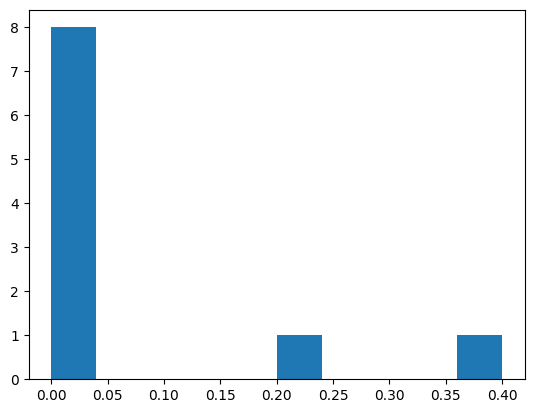

In [55]:
import matplotlib.pyplot as plt
plt.hist(prec,bins=10)

Testing precision by different components (abstract, author, co-citations)

In [56]:
import matplotlib.pyplot as plt

(array([6., 0., 2., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

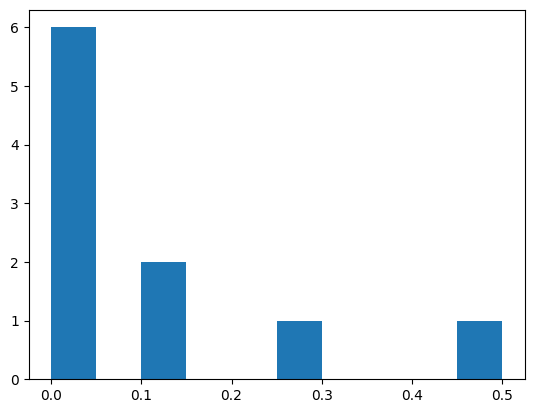

In [57]:
prec = []
for title in test:
    res = reccPaper(title, include_auth=False)
    prec.append(res[1]/len(res[0]))
plt.hist(prec,bins=10)

Text(0.5, 0, 'Precision')

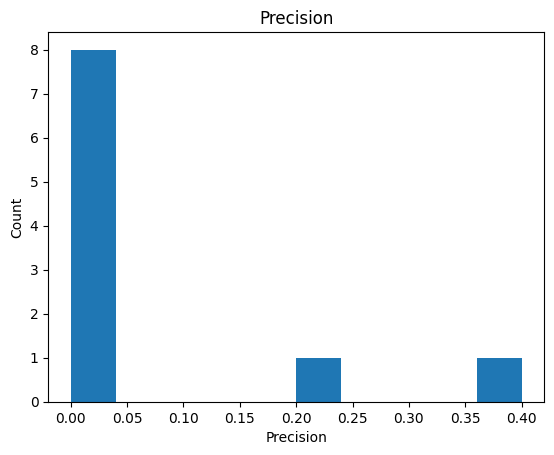

In [58]:
prec = []
for title in test:
    res = reccPaper(title)
    # print(res)
    if len(res[0]) == 0:
        prec.append(0)
    else:
        prec.append(res[1]/len(res[0]))
plt.hist(prec,bins=10)
plt.title("Precision")
plt.ylabel("Count")
plt.xlabel("Precision")

Text(0.5, 0, 'Precision')

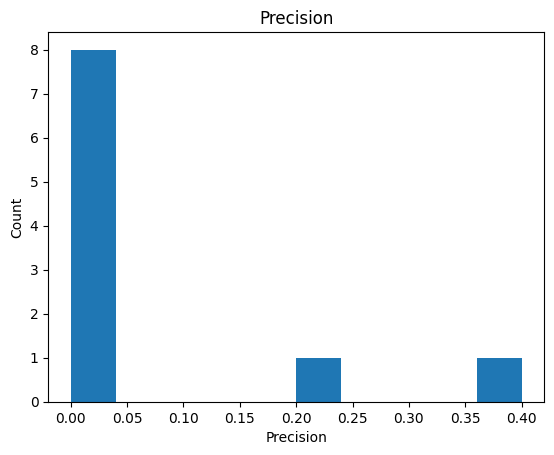

In [59]:
plt.hist(prec,bins=10)
plt.title("Precision")
plt.ylabel("Count")
plt.xlabel("Precision")

Text(0.5, 1.0, 'Histogram of precision')

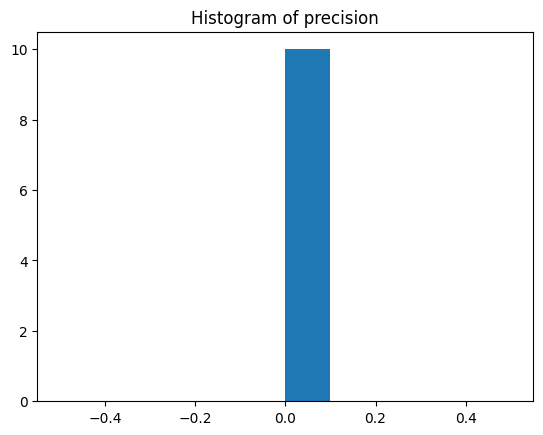

In [60]:
prec = []
for title in test:
    res = reccPaper(title, include_abs=False, include_cite=False)
    if len(res[0]) == 0:
        prec.append(0)
    else:
        prec.append(res[1]/len(res[0]))
plt.hist(prec,bins=10)
plt.title("Histogram of precision")

Scaling Graph

In [61]:
import time
unbatch = []
batch = []
# input_sizes = [100, 500, 1000, 5000]
input_sizes = [1,10]
for input_size in input_sizes:
    test = random.sample(titles, input_size)
    start = time.time()
    for i in test:
        reccPaper(i)
    unbatch.append(time.time()-start)

    start = time.time()
    reccPaper_batch(test)
    batch.append(time.time()-start)   

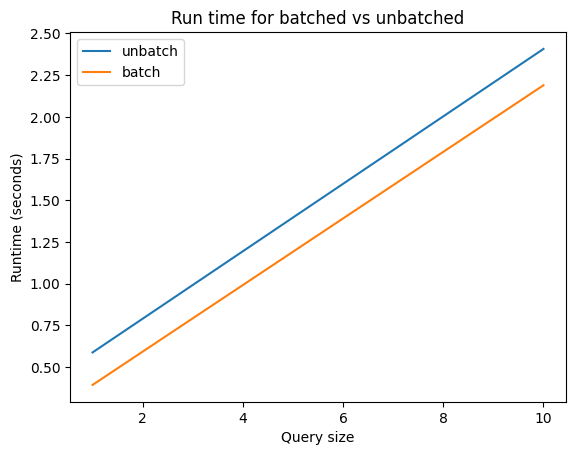

In [62]:
plt.plot(input_sizes,unbatch,label='unbatch')
plt.plot(input_sizes,batch,label='batch')
plt.title("Run time for batched vs unbatched")
plt.xlabel("Query size")
plt.ylabel("Runtime (seconds)")
plt.legend()